# LDA

## Import Package

In [1]:
import re
import pandas as pd
import spacy
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora

## Data Preprocess

In [2]:
df = pd.read_csv('wiki.csv')

In [61]:
len(df)

2284

In [3]:
title = df.title.values

In [4]:
data = df.text.values.tolist()
data = [re.sub('\s+', ' ', d) for d in data]
data = [re.sub("\'", "", d) for d in data]
data = [re.sub("\[", "", d) for d in data]
data = [re.sub("\]", "", d) for d in data]
data = [re.sub("\{", "", d) for d in data]
data = [re.sub("\}", "", d) for d in data]

In [5]:
irrelvent_words = ['http', 'https', 'access', 'category', 'date', 'cite', 'archive', 'title', 'access']

In [6]:
def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and token not in irrelvent_words and len(token) > 3:
            result.append(token)  
    return result

In [7]:
data_preprocessed = [preprocess(d) for d in data]

In [8]:
def make_trigrams(data):
    bigram = gensim.models.Phrases(data, min_count=5, threshold=100)
    trigram = gensim.models.Phrases(bigram[data], threshold=100)  

    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    return [trigram_mod[bigram_mod[d]] for d in data]

In [9]:
data_trigrams = make_trigrams(data_preprocessed)

In [10]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for t in texts:
        doc = nlp(" ".join(t)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [11]:
data_lemmatized = lemmatization(data_trigrams)

In [12]:
id2word = corpora.Dictionary(data_lemmatized)

In [13]:
corpus = [id2word.doc2bow(text) for text in data_lemmatized]

## Modeling

In [14]:
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

In [15]:
def gs_for_topics(num_topics):
    coherences = []
    for num_topic in num_topics:
        print(num_topic)
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topic, 
                                           update_every=1,
                                           chunksize=500,
                                           passes=20,
                                           alpha='auto')
        coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
        coherences.append(coherence_model_lda.get_coherence())
    return coherences

In [16]:
num_topics = [3, 5, 10, 15, 20, 30]
coherences = gs_for_topics(num_topics)

3
5
10
15
20
30


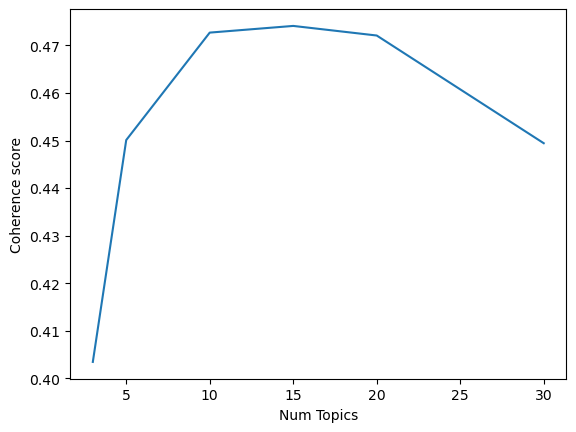

In [17]:
plt.plot(num_topics, coherences)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.show()

In [18]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=15, 
                                           update_every=1,
                                           chunksize=500,
                                           passes=20,
                                           alpha='auto')

In [19]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.17975297595086

Coherence Score:  0.4921789984727418


In [20]:
lda_model.print_topics(num_words=10)

[(0,
  '0.123*"ship" + 0.021*"destroyer" + 0.018*"norwegian" + 0.018*"naval" + 0.016*"convoy" + 0.016*"sink" + 0.014*"publisher" + 0.012*"german" + 0.011*"arrive" + 0.011*"boat"'),
 (1,
  '0.054*"heath" + 0.026*"government" + 0.021*"election" + 0.017*"conservative" + 0.012*"prime_minister" + 0.011*"political" + 0.011*"vote" + 0.010*"opposition" + 0.009*"politic" + 0.008*"party"'),
 (2,
  '0.025*"polish" + 0.016*"world" + 0.015*"cemetery" + 0.015*"die" + 0.012*"soldier" + 0.012*"military" + 0.010*"kill" + 0.010*"german" + 0.010*"battle" + 0.009*"officer"'),
 (3,
  '0.023*"city" + 0.016*"soviet" + 0.015*"german" + 0.013*"stalingrad" + 0.012*"hitler" + 0.011*"raid" + 0.011*"bomb" + 0.011*"building" + 0.010*"bombing" + 0.010*"people"'),
 (4,
  '0.031*"squadron" + 0.028*"force" + 0.027*"fighter" + 0.026*"aircraft" + 0.019*"bomber" + 0.016*"fly" + 0.015*"pilot" + 0.014*"attack" + 0.014*"battle" + 0.014*"wing"'),
 (5,
  '0.044*"estonian" + 0.015*"baltic" + 0.013*"laar" + 0.011*"leningrad" + 0

## Visualization

In [21]:
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.239993 -0.013677       1        1  24.381431
9      0.256406 -0.129716       2        1  23.067496
4      0.244379 -0.023743       3        1  14.001592
14     0.149121  0.209412       4        1   8.714561
11     0.202080 -0.272155       5        1   7.647604
10     0.203916  0.117269       6        1   7.619096
2      0.158650  0.112476       7        1   5.265559
3      0.121594  0.138551       8        1   4.780191
0      0.151017 -0.073981       9        1   3.754923
5     -0.283925 -0.016898      10        1   0.292924
1     -0.278381  0.000294      11        1   0.225663
12    -0.293830 -0.016333      12        1   0.124574
13    -0.292972 -0.015815      13        1   0.115486
8     -0.289203 -0.008019      14        1   0.007172
6     -0.288844 -0.007666      15        1   0.001728, topic_info=                   Term          Freq         Total Category  logprob  loglift
257            division  27439.000000  27439.000000  Default  30.0000  30.0000
697                ship   8924.000000   8924.000000  Default  29.0000  29.0000
391            infantry  10953.000000  10953.000000  Default  28.0000  28.0000
1157               film   7391.000000   7391.000000  Default  27.0000  27.0000
626            regiment   7397.000000   7397.000000  Default  26.0000  26.0000
...                 ...           ...           ...      ...      ...      ...
26231          interval      0.000492      0.787291  Topic15 -11.0997   3.5886
32828             hesse      0.000492      0.787055  Topic15 -11.0997   3.5889
33680              goer      0.000492      0.787066  Topic15 -11.0997   3.5888
38907  severely_damaged      0.000492      0.787246  Topic15 -11.0997   3.5886
40656              hose      0.000492      0.787091  Topic15 -11.0997   3.5888

[1036 rows x 6 columns], token_table=       Topic      Freq                Term
term                                      
8073       1  0.998634              aachen
2429       3  0.988221                 ace
2429       6  0.010712                 ace
6673      13  0.746220            actinium
840        1  0.129353              action
...      ...       ...                 ...
16721     13  0.891995               żmija
14929      7  0.970764            żoliborz
21295     13  0.957354          żurakowski
13857      2  0.207143  стрелковая_дивизия
13857     12  0.621428  стрелковая_дивизия

[2443 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 10, 5, 15, 12, 11, 3, 4, 1, 6, 2, 13, 14, 9, 7])

## Analysis

In [22]:
vector = lda_model[corpus[0]]

In [23]:
vector[0]

(2, 0.3355702)

## Recommendation

In [24]:
import numpy as np
from gensim import similarities
index = similarities.MatrixSimilarity(lda_model[corpus])

In [25]:
def recommend(words):
    words = id2word.doc2bow(words)
    sims = index[lda_model[words]]
    return title[np.argsort(-sims)[:5]]

In [26]:
recommend(['german', 'tank'])

array(['Battle of Arracourt', 'Second Battle of Kharkov',
       'Belgrade offensive', 'Battle of Bryansk (1941)',
       'Operation Charnwood'], dtype=object)

In [73]:
recommend(['air', 'bomb'])

array(["That's All, Brother", 'Portsmouth Blitz', 'Cardiff Blitz',
       'Operation Cedar', 'Bombing of Nordhausen in World War II'],
      dtype=object)

In [75]:
recommend(['nazi'])

array(['Operation Epsilon', 'Adolf Opálka', 'Leslie Groves', 'Karl Wirtz',
       'Dunkirk (1958 film)'], dtype=object)

# PMF

## import package

In [29]:
import numpy as np
import time

from surprise import SVD, SVDpp, CoClustering, NMF, SlopeOne, KNNBaseline
from surprise import Dataset
from surprise.model_selection import cross_validate

## cross validation

In [30]:
def run_algo(algo, algo_name):
    t = time.time()
    result = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)
    rmse = np.mean(result['test_rmse'])
    mae = np.mean(result['test_mae'])
    print(f"{algo_name} RMSE: {rmse} MAE: {mae} time: {time.time() - t:.4}s")


In [31]:
# data
data = Dataset.load_builtin("ml-100k")

In [32]:
movies = pd.read_csv(data.ratings_file[:-6] + 'u.item', sep='|',  encoding='latin-1', names=['id', 'title', 'release date', 'video release data', 'URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])

In [33]:
svd = SVD()
run_algo(svd, 'SVD')

SVD RMSE: 0.9372976269196261 MAE: 0.7386743506010806 time: 2.322s


In [34]:
nmf = NMF()
run_algo(nmf, 'NMF')

NMF RMSE: 0.9622990783562365 MAE: 0.7574672079241946 time: 2.78s


In [35]:
slope_one = SlopeOne()
run_algo(slope_one, 'SlopeOne')

SlopeOne RMSE: 0.9448954730186803 MAE: 0.7426511765266386 time: 4.579s


In [36]:
knn_baseline = KNNBaseline()
run_algo(knn_baseline, 'KNNBaseline')

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
KNNBaseline RMSE: 0.9300326910058436 MAE: 0.7327467223666453 time: 6.387s


In [37]:
svdpp = SVDpp()
run_algo(svdpp, 'SVD++')

SVD++ RMSE: 0.9188621811339746 MAE: 0.7214763595957602 time: 50.64s


In [38]:
co_clustering = CoClustering()
run_algo(co_clustering, 'CoClustering')

CoClustering RMSE: 0.9655736319862168 MAE: 0.7552963178788955 time: 2.485s


In [39]:
from surprise.model_selection import train_test_split

trainset, testset = train_test_split(data, test_size=0.25)

algo = SVD()
algo.fit(trainset)
predictions = algo.test(testset)

In [40]:
def pred_of_user(user):
    res = []
    for pred in predictions:
        if pred.uid == str(user):
            res.append(pred)
    return res

In [42]:
def print_topK_of_user(user, topk=5):
    results = pred_of_user(user)
    results = sorted(results, key=lambda x: x.est, reverse=True)
    print(f'Moive Name\t\t\t\t\t\tActual Rating\tPredicted Rating')
    for i, res in enumerate(results):
        if i > topk:
            break
        print(f"{movies.iloc[int(res.iid), 1]:<60}{res.r_ui:<5.4}\t{res.est:.4}") 

In [43]:
print_topK_of_user(1)

Moive Name						Actual Rating	Predicted Rating
Supercop (1992)                                             5.0  	4.842
Cinema Paradiso (1988)                                      5.0  	4.833
Brazil (1985)                                               5.0  	4.713
What's Eating Gilbert Grape (1993)                          5.0  	4.633
Three Colors: Blue (1993)                                   5.0  	4.452
12 Angry Men (1957)                                         5.0  	4.381


In [44]:
for i in range(5000):
    results = pred_of_user(i)
    results = sorted(results, key=lambda x: x.est, reverse=True)
    if len(results) > 0 and results[0].r_ui < 3.0:
        print(i)

38
39
50
61
80
98
101
124
150
166
181
215
234
238
255
281
301
302
331
353
374
389
396
410
418
446
566
578
593
604
628
657
685
724
726
756
765
770
792
825
833
843
878
881


In [45]:
print_topK_of_user(35)

Moive Name						Actual Rating	Predicted Rating
Dante's Peak (1997)                                         3.0  	2.982
Washington Square (1997)                                    2.0  	2.94
Murder at 1600 (1997)                                       3.0  	2.843
Event Horizon (1997)                                        4.0  	2.783
Assignment, The (1997)                                      1.0  	2.759
Smilla's Sense of Snow (1997)                               2.0  	2.431


In [46]:
print_topK_of_user(50)

Moive Name						Actual Rating	Predicted Rating
Marvin's Room (1996)                                        2.0  	3.925
Full Monty, The (1997)                                      4.0  	3.706
Spitfire Grill, The (1996)                                  2.0  	3.425
My Left Foot (1989)                                         5.0  	3.405
Vampire in Brooklyn (1995)                                  4.0  	3.24
Great White Hype, The (1996)                                3.0  	2.73


In [47]:
print_topK_of_user(238)

Moive Name						Actual Rating	Predicted Rating
Sleeper (1973)                                              2.0  	3.986
Marvin's Room (1996)                                        5.0  	3.708
Dragonheart (1996)                                          4.0  	3.498
George of the Jungle (1997)                                 3.0  	3.386
When the Cats Away (Chacun cherche son chat) (1996)         3.0  	3.17
Mouse Hunt (1997)                                           4.0  	3.132


In [48]:
cnt = 0
for d in data.raw_ratings:
    if d[0] == '50':
        cnt += 1
print(cnt)

24
